In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import markov_clustering as mc
import random
from tqdm import tqdm_notebook as tqdm
import os
import git
import pandas as pd
import ast

In [21]:
import matplotlib
matplotlib.use('Agg')

In [4]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

In [6]:
# edgelist_path = os.path.join(get_git_root(os.getcwd()),"models","user-user_c.edgelist")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")

In [10]:
# G = nx.read_edgelist(edgelist_path,create_using=nx.DiGraph())

In [11]:
len(G.nodes())

5402

In [12]:
poly_users_path = os.path.join(get_git_root(os.getcwd()),"models","poly_users")
poly_users = pickle.load(open(os.path.join(poly_users_path,"poly_users.pkl"),"rb"))
total_users = pickle.load(open(os.path.join(poly_users_path,"total_users.pkl"),"rb"))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")

In [13]:
df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [14]:
## selecting a subset of the following that contain the total users
df_rem_users = df_following_final[df_following_final.userID.isin(total_users)]

In [15]:
# total user
len(total_users)

2878

In [103]:
### building the network
G = nx.DiGraph()
for user in tqdm(list(df_rem_users.userID)):
    following_A = set(ast.literal_eval((df_rem_users.loc[df_rem_users.userID == user].head(1)["following"].values)[0]))
    user_set = set([node for node in total_users if node != user])
    users_list = user_set.intersection(following_A)
    for user_following in list(users_list):
        G.add_edge(user,user_following)

In [107]:
len(G.nodes())

1775

In [109]:
len(poly_users)

385

In [110]:
# color map 
color_map = list()
for node in G.nodes():
    if int(node) in poly_users:
        color_map.append('blue')
    else:
        color_map.append('green')

In [111]:
len(total_users)

2878

In [131]:
## new one saved in following dir <models,poly_users, following_network.pdf>
plt.figure(figsize=(30,30))
nx.draw(G,node_color=color_map)
plt.savefig(os.path.join(model_dir,"poly_users","following_network.pdf"))

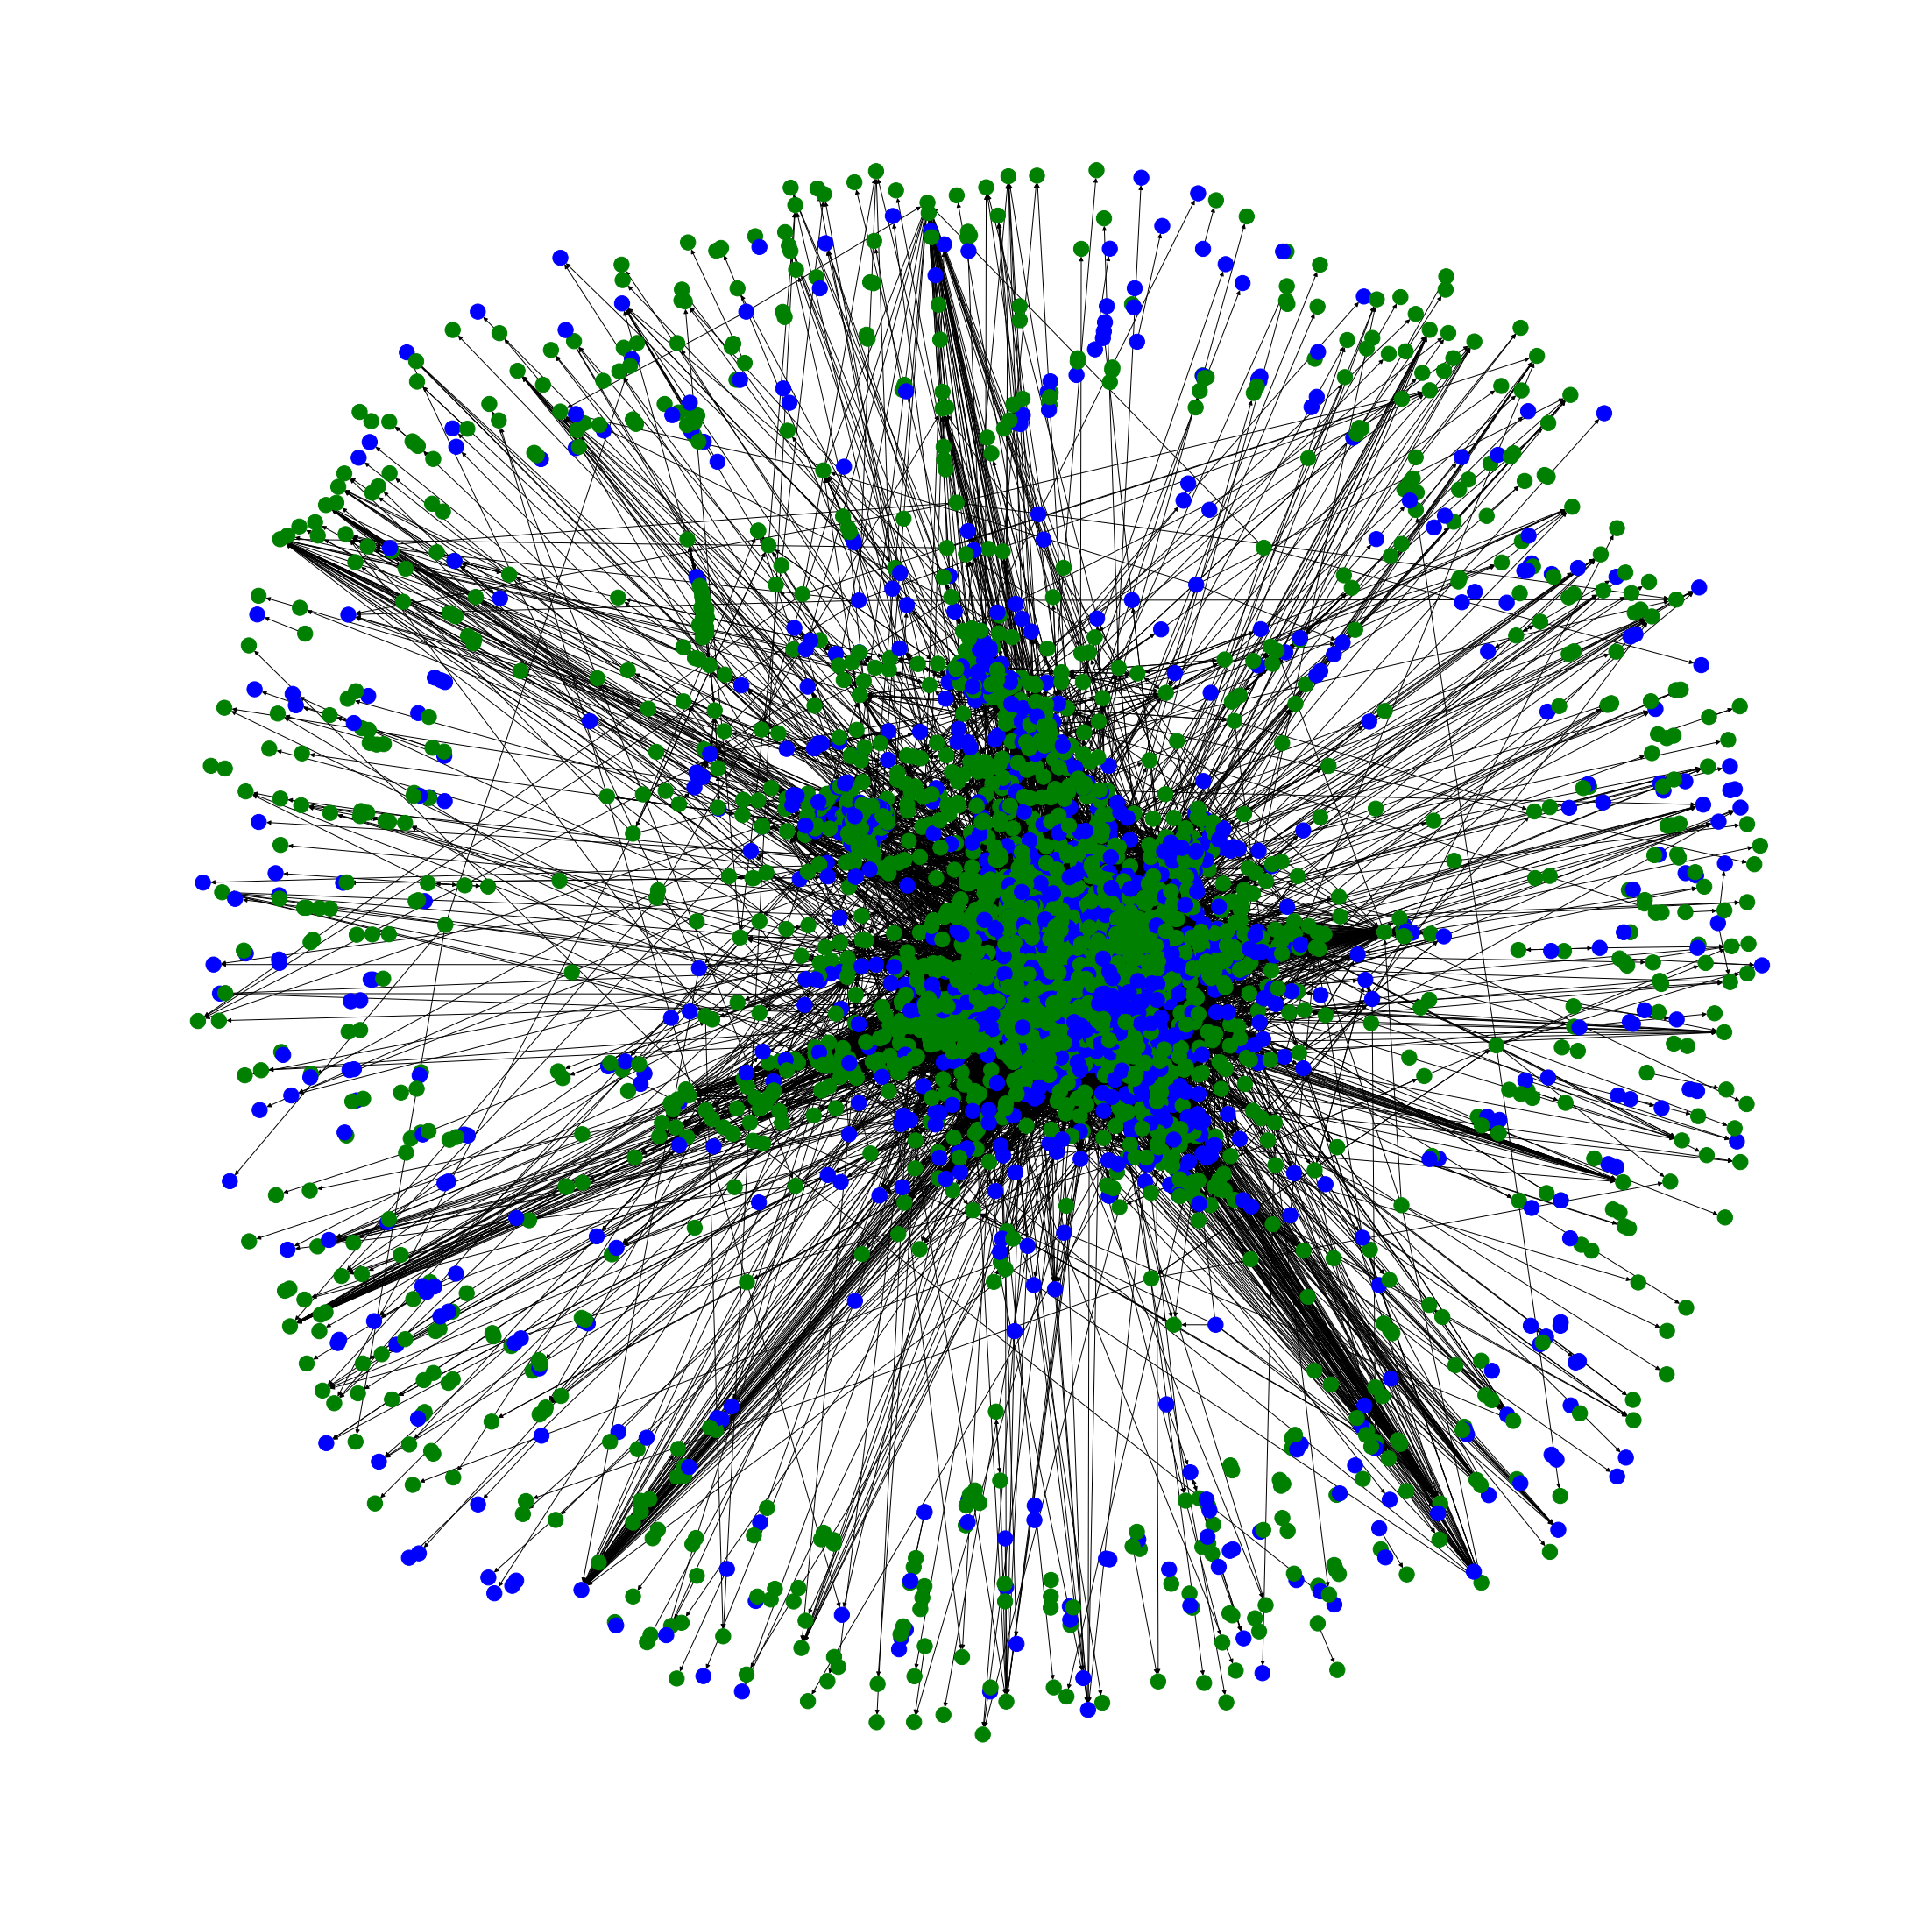

In [177]:
## old one  !! dont run
plt.figure(figsize=(30,30))
nx.draw(G,node_color=color_map)
plt.savefig("following_network.pdf")

## graph statistics

In [133]:
## degree of the nodes
x = (list(G.degree()))
x.sort(key= lambda x:x[1],reverse=True)
# (sorted_x[5201:])

In [134]:
from itertools import groupby
from operator import itemgetter
X = [list(group) for key,group in groupby(x,itemgetter(1))]

In [135]:
x0 = [str(ele[0]) for ele in x][:50]
x1 = [(ele[1]) for ele in x][:50]

In [136]:
nodes = dict()
i = 800
while i >= 50:
    begin = i - 50
    count = 0
    for ele in x:
        if begin <= ele[1] <= i:
            count += 1
            nodes[begin] = count 
    i = i - 50

In [137]:
nodes

{0: 1554, 50: 120, 100: 51, 150: 34, 200: 14, 250: 6, 300: 1, 350: 1}

In [138]:
x_axis = list()
y_axis = list()
for key, value in nodes.items():
    x_axis.append(key)
    y_axis.append(value)

In [140]:
plt.figure(figsize=(15,10))
plt.plot(x_axis,y_axis)
plt.show()

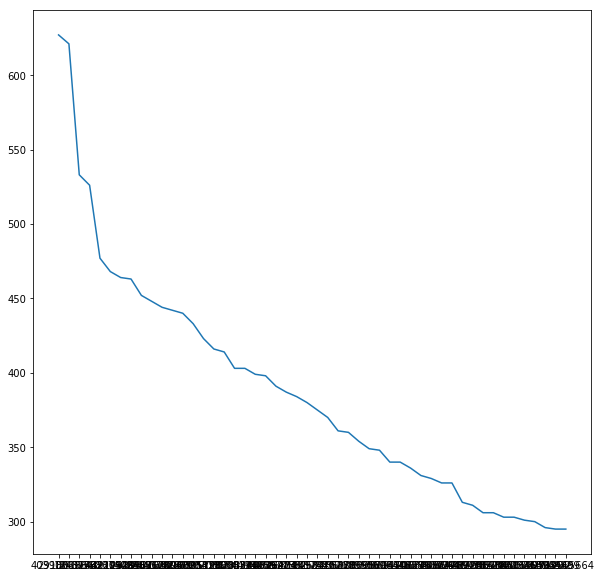

In [22]:
plt.figure(figsize=(10,10))
plt.plot(x0,x1)
plt.show()

## using MICL to find communities and within it which are the poly1 and poly2 users

In [16]:
G = nx.read_gpickle(os.path.join(model_dir,"poly_users","following_net_new.gpickle"))

In [17]:
# getting the sparse matrix from the main graph
matrix = nx.to_scipy_sparse_matrix(G)

In [18]:
result = mc.run_mcl(matrix)

In [19]:
clusters = mc.get_clusters(result)  

In [22]:
plt.figure(figsize=(100,100))
mc.draw_graph(matrix, clusters, node_size=50, with_labels=False, edge_color="silver")
file_name = os.path.join(model_dir,"poly_users","communities.pdf")
plt.savefig(file_name)

/home/samarthgoal/.local/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [23]:
len(G.nodes)

1775

/home/akshayuppal2345/.local/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


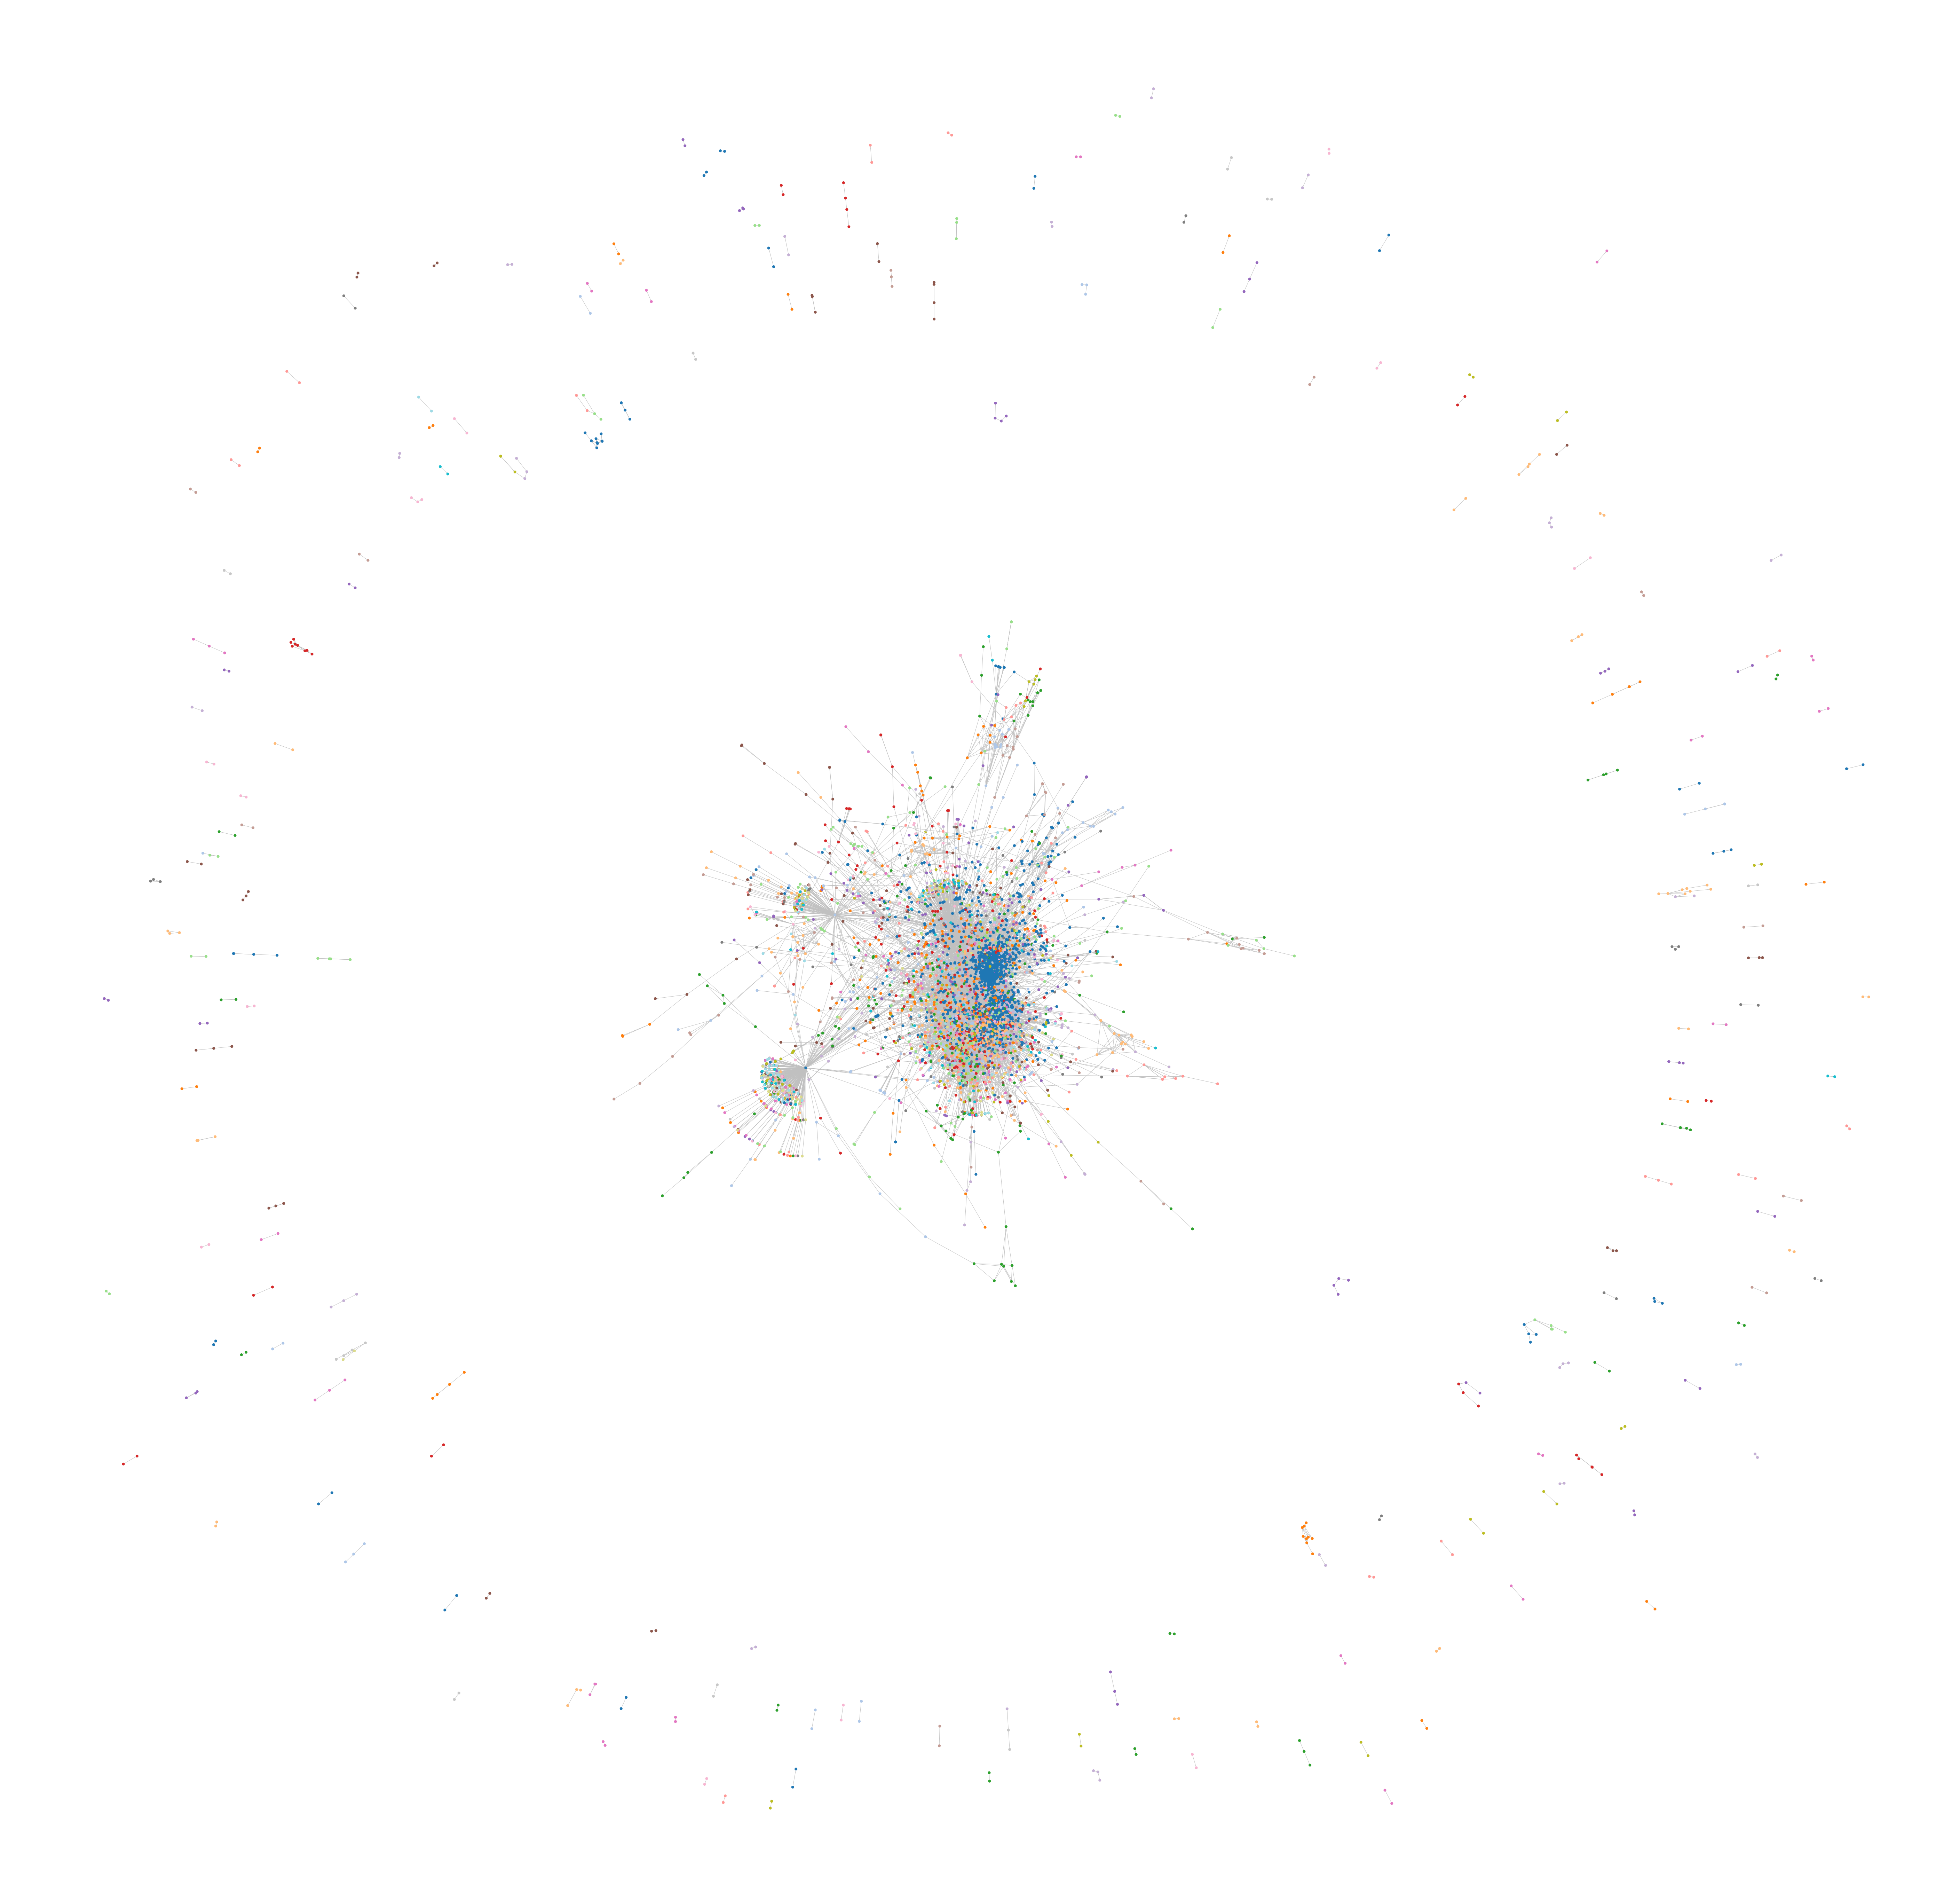

In [172]:
plt.figure(figsize=(100,100))
mc.draw_graph(matrix, clusters, node_size=50, with_labels=False, edge_color="silver")
plt.savefig("communities.pdf")

In [27]:
sub_clusters = [cluster for cluster in clusters if len(cluster) > 50]

In [29]:
# so there are 5 big clusters who have community size > 50
len(sub_clusters)

5

## changing the inflation parmeter

/home/akshayuppal2345/.local/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


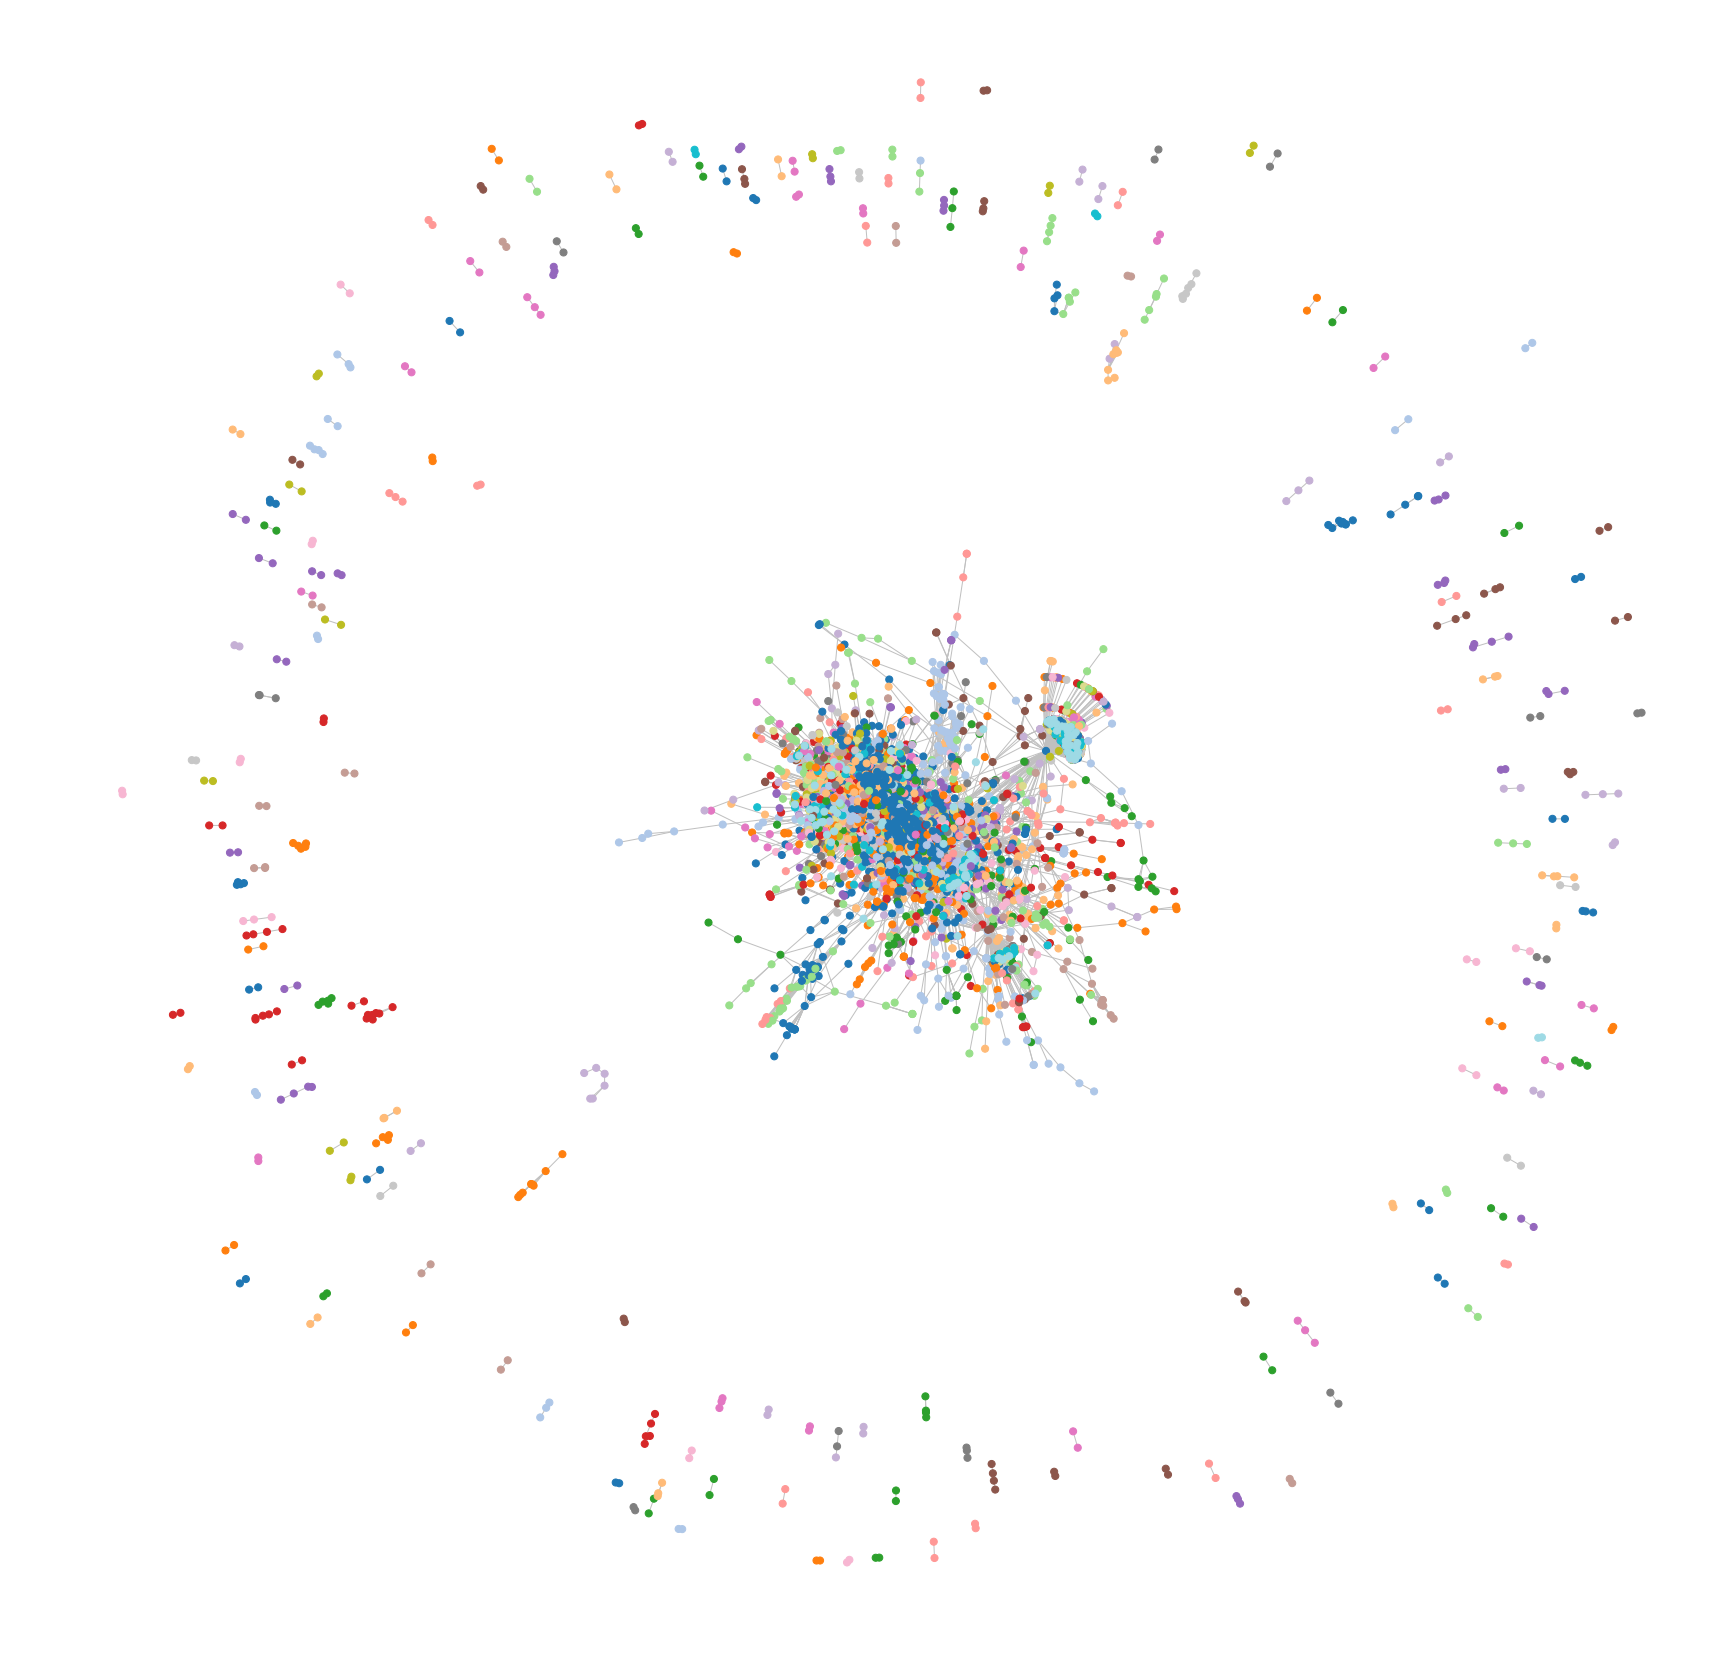

In [37]:
result = mc.run_mcl(matrix, inflation=1.4)
clusters = mc.get_clusters(result)
plt.figure(figsize=(30,30))
mc.draw_graph(matrix, clusters, node_size=50, with_labels=False, edge_color="silver")

In [ ]:
## adjusting the parameters
for inflation in tqdm([i / 10 for i in range(15, 26)]):
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

In [ ]:
# cluster using the optimized cluster inflation value
result = mc.run_mcl(matrix, inflation=2.1)
clusters = mc.get_clusters(result)
mc.draw_graph(matrix, clusters, pos=positions, node_size=50, with_labels=False, edge_color="silver")

In [127]:
## dump the graph
nx.write_gpickle(G, os.path.join(model_dir,"poly_users","following_network_new.gpickle"))